In [1]:
!pip install matplotlib
!pip install pandas
!pip install numpy
!pip install psutil
!pip install py-cpuinfo

  Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp39-cp39-macosx_10_9_universal2.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.7-cp39-cp39-macosx_11_0_arm64.whl.metadata (6.3 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached pillow-11.1.0-cp39-cp39-macosx_11_0_arm64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.1-py3-none-any.whl.metadata (5.0 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
Using cached matplotlib-3.9.4-cp39-cp39-macosx_11_0_arm64.whl (7.8 MB)
Using cached contourpy-1.3.0-cp39-cp39-macosx_11_0_arm64.whl (249 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp39-cp39-macosx_10_9_universal2.whl (2.8 MB)
Using cached importlib_resources-6.5.2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm 
import cpuinfo
from random import randint
import numpy as np
import platform
import pandas as pd  
import psutil
import subprocess
import time

max_number = 1000           # Максимальное число в массиве
min_number = -1000          # Минимальное число в массиве
filename = "text.txt"

def generate(length):
    file = open(filename, 'w')
    for i in range(1, length):
        file.write(str(randint(min_number, max_number)) + '\n')
    file.close()

def test(length, proc):
    generate(length)
    start_time = time.perf_counter()
    
    process = subprocess.Popen(
        [proc],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )
    
    process.wait()
    end_time = time.perf_counter()
    
    return end_time - start_time

def measure_cpu_usage(interval=1.0, proc=""):
    process = subprocess.Popen(
        [proc],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True
    )

    timestamps = []
    process_cpu_usage = []
    all_cores_usage = [[] for _ in range(psutil.cpu_count(logical=True))]

    start_time = time.perf_counter()
    num_cores = psutil.cpu_count(logical=True)

    while process.poll() is None:
        if psutil.pid_exists(process.pid):
            try:
                proc = psutil.Process(process.pid)
                cpu_usage = proc.cpu_percent(interval=interval) / num_cores
                
                timestamps.append(time.perf_counter() - start_time)
                process_cpu_usage.append(cpu_usage)
                core_usages = psutil.cpu_percent(interval=0, percpu=True)

                for i, usage in enumerate(core_usages):
                    all_cores_usage[i].append(usage)

            except psutil.NoSuchProcess:
                break  

        time.sleep(interval)

    process.wait()
    return timestamps, process_cpu_usage, all_cores_usage

In [3]:
def get_cpu_name():
    system_name = platform.system()

    if system_name == "Windows":
        return platform.processor()
    
    elif system_name == "Darwin":
        try:
            return subprocess.check_output(["sysctl", "-n", "machdep.cpu.brand_string"]).strip().decode()
        except Exception:
            return "Apple Silicon (Unknown)"
    
    elif system_name == "Linux":
        try:
            return cpuinfo.get_cpu_info()['brand_raw']
        except Exception:
            return "Unknown CPU"

    return "Unknown CPU"

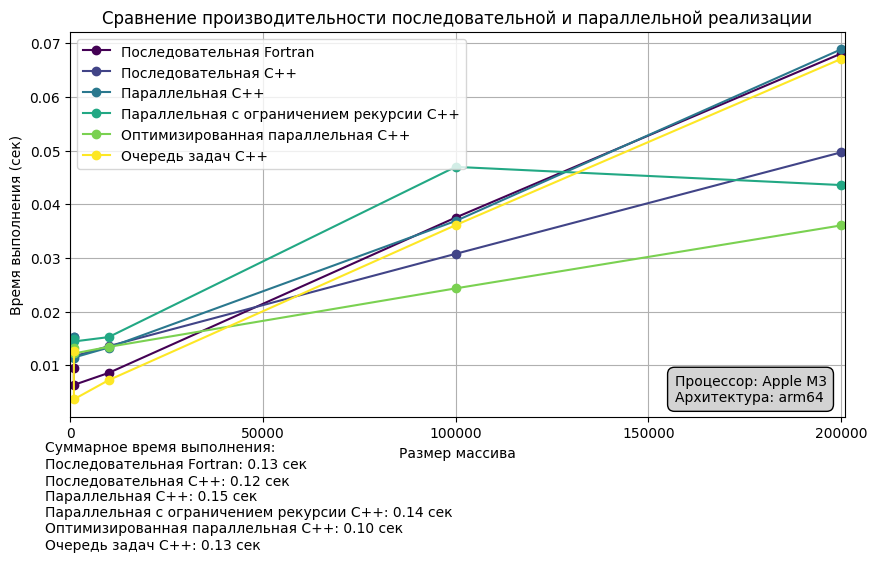

In [42]:
cpu_name = get_cpu_name()
architecture = platform.machine()

sizes = [1000, 1000, 10000, 100000, 200000]

implementations = {
    "Последовательная Fortran": "./fortran_test/main",
    "Последовательная C++": "./c_test/main",
    "Параллельная C++": "./c_parall_test/main",
    "Параллельная с ограничением рекурсии C++": "./c_parall_true/main",
    "Оптимизированная параллельная C++": "./c_parall_opt/main",
    "Очередь задач C++": "./c_task_bar/main",
}

times = {name: [test(size, path) for size in sizes] for name, path in implementations.items()}
colors = cm.viridis(np.linspace(0, 1, len(implementations)))

plt.figure(figsize=(10, 5))

for (name, time_values), color in zip(times.items(), colors):
    plt.plot(sizes, time_values, marker='o', linestyle='-', color=color, label=name)

plt.xlabel("Размер массива")
plt.ylabel("Время выполнения (сек)")
plt.title("Сравнение производительности последовательной и параллельной реализации")
plt.legend()
plt.grid(True)

plt.xlim(sizes[0], sizes[-1] + 1000)
plt.xticks(range(0, sizes[-1] + 500, 50000))

summary_text = "Суммарное время выполнения:\n" + "\n".join(
    [f"{name}: {np.sum(time_values):.2f} сек" for name, time_values in times.items()]
)
plt.figtext(0.1, -0.15, summary_text, ha="left", fontsize=10, wrap=True)

cpu_info = f"Процессор: {cpu_name}\nАрхитектура: {architecture}"
plt.text(0.78, 0.04, cpu_info, transform=plt.gca().transAxes,
         fontsize=10, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))

plt.show()

/var/folders/lz/1l8c_gc975x2qlsbl1v1gpqr0000gn/T/ipykernel_28164/13125794.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_smooth.columns))


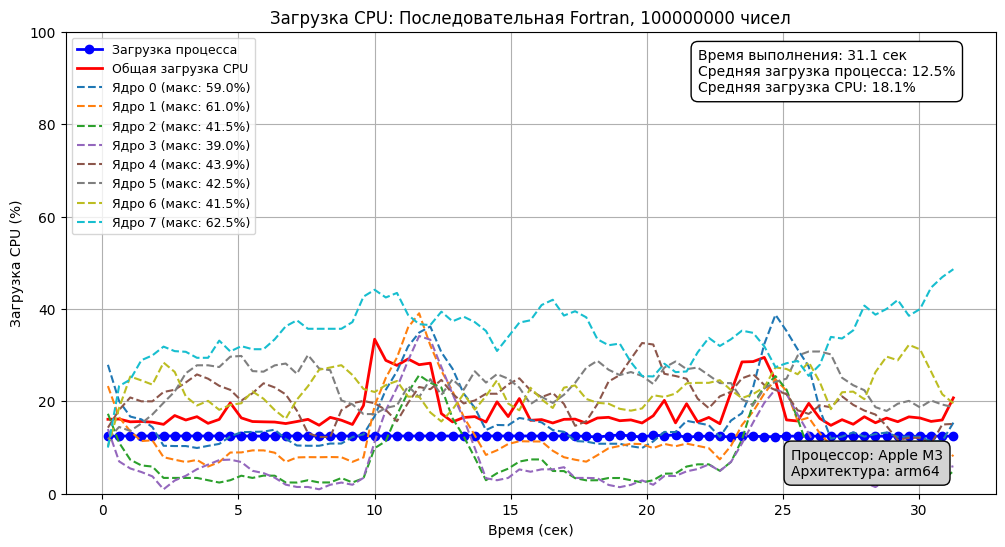

/var/folders/lz/1l8c_gc975x2qlsbl1v1gpqr0000gn/T/ipykernel_28164/13125794.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_smooth.columns))


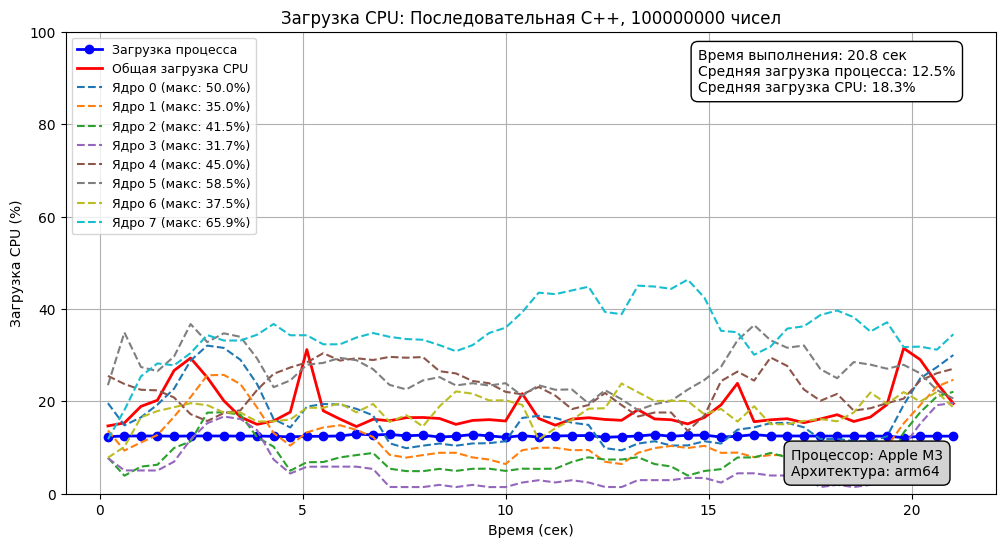

/var/folders/lz/1l8c_gc975x2qlsbl1v1gpqr0000gn/T/ipykernel_28164/13125794.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_smooth.columns))


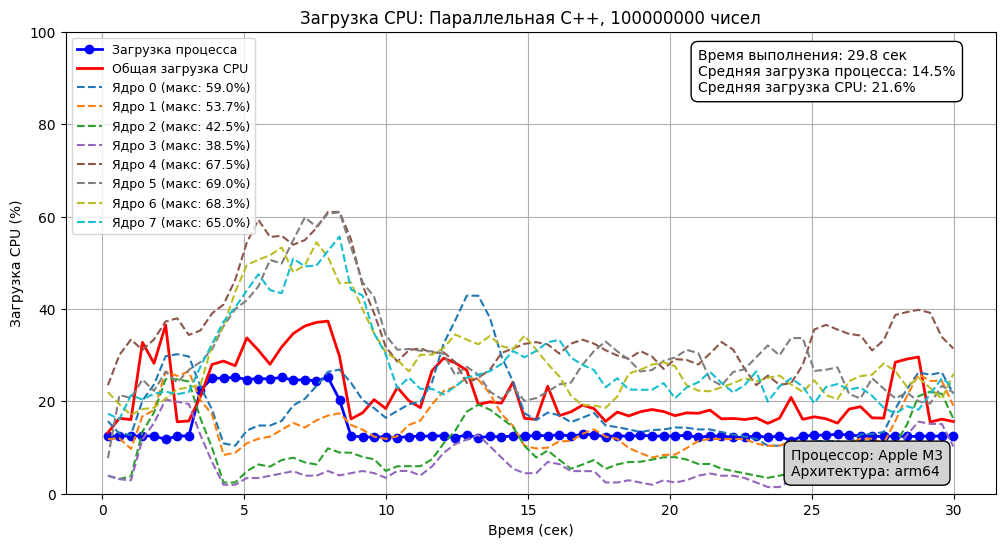

/var/folders/lz/1l8c_gc975x2qlsbl1v1gpqr0000gn/T/ipykernel_28164/13125794.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_smooth.columns))


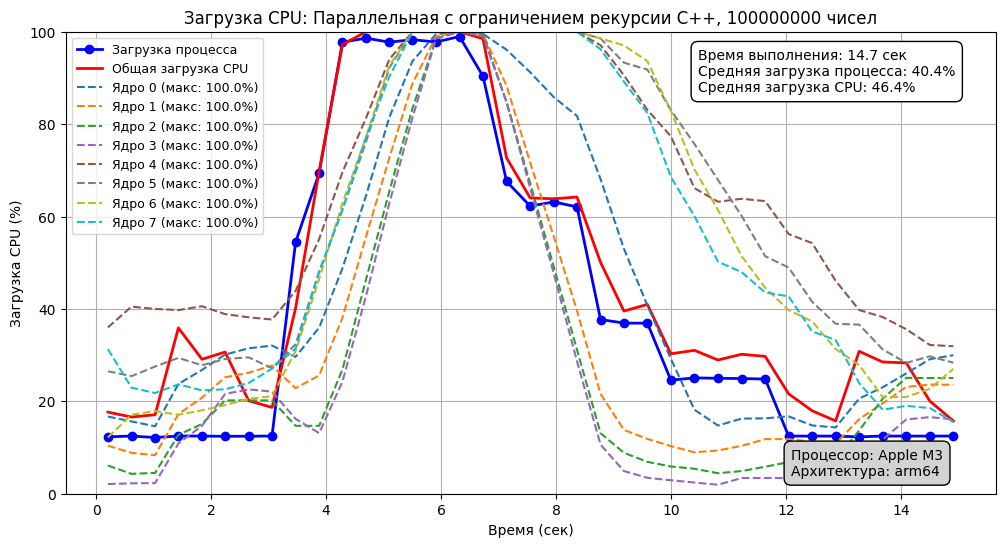

/var/folders/lz/1l8c_gc975x2qlsbl1v1gpqr0000gn/T/ipykernel_28164/13125794.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_smooth.columns))


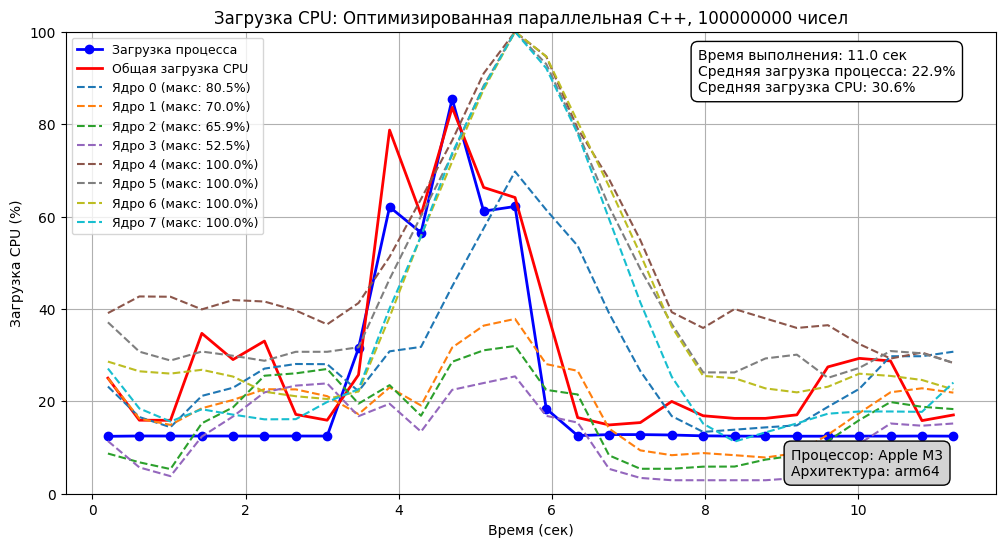

/var/folders/lz/1l8c_gc975x2qlsbl1v1gpqr0000gn/T/ipykernel_28164/13125794.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(df_smooth.columns))


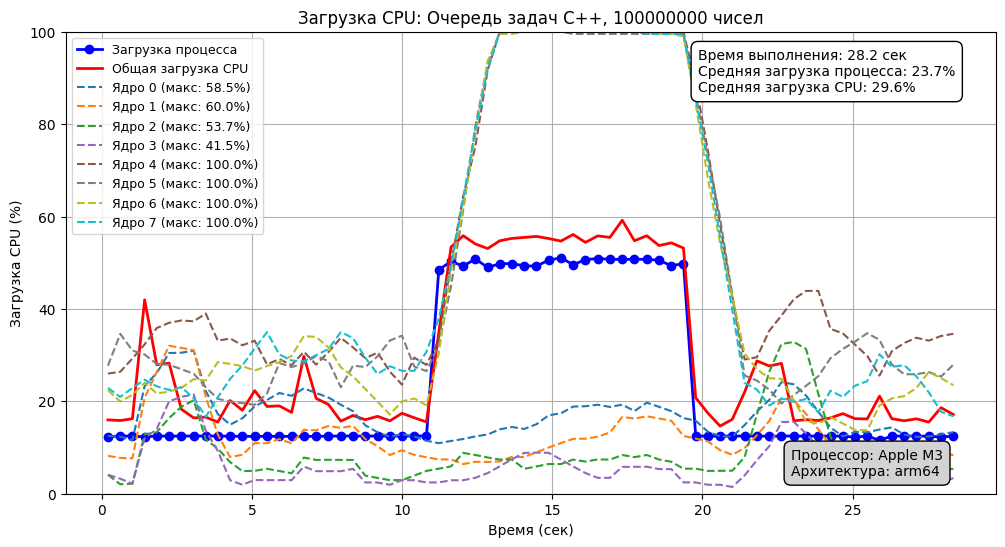

In [5]:
cpu_name = get_cpu_name()
architecture = platform.machine()

length = 100000000
generate(length)

processes = {
    "Последовательная Fortran": "./fortran_test/main",
    "Последовательная C++": "./c_test/main",
    "Параллельная C++": "./c_parall_test/main",
    "Параллельная с ограничением рекурсии C++": "./c_parall_true/main",
    "Оптимизированная параллельная C++": "./c_parall_opt/main",
    "Очередь задач C++": "./c_task_bar/main"
}

def plot_cpu_usage(proc_name, proc_path):
    timestamps, process_cpu_usage, all_cores_usage = measure_cpu_usage(interval=0.2, proc=proc_path)

    df = pd.DataFrame({f"Ядро {i}": usage for i, usage in enumerate(all_cores_usage)}, index=timestamps)
    df_smooth = df.rolling(window=5, min_periods=1).mean()

    plt.figure(figsize=(12, 6))
    plt.plot(timestamps, process_cpu_usage, marker='o', linestyle='-', color='b', linewidth=2, label="Загрузка процесса")
    corrected_total_cpu_usage = df.mean(axis=1)
    plt.plot(timestamps, corrected_total_cpu_usage, linestyle='-', color='r', linewidth=2, label="Общая загрузка CPU")


    colors = plt.cm.get_cmap("tab10", len(df_smooth.columns))

    legend_labels = ["Загрузка процесса", "Общая загрузка CPU"]
    for i, core in enumerate(df_smooth.columns):
        max_val = df[core].max()
        plt.plot(timestamps[:len(df_smooth[core])], df_smooth[core], linestyle='--', color=colors(i))
        legend_labels.append(f"{core} (макс: {max_val:.1f}%)")

    plt.xlabel("Время (сек)")
    plt.ylabel("Загрузка CPU (%)")
    plt.title(f"Загрузка CPU: {proc_name}, {length} чисел")
    plt.legend(legend_labels, loc="upper left", fontsize=9)
    plt.grid(True)
    plt.ylim(0, 100)

    plt.text(0.78, 0.04, cpu_info, transform=plt.gca().transAxes,
             fontsize=10, bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.5'))
    avg_process_usage = np.mean(process_cpu_usage)
    avg_total_cpu_usage = np.mean(df.mean(axis=1))

    runtime_text = f"Время выполнения: {timestamps[-1] - timestamps[0]:.1f} сек\n" \
               f"Средняя загрузка процесса: {avg_process_usage:.1f}%\n" \
               f"Средняя загрузка CPU: {avg_total_cpu_usage:.1f}%"

    plt.text(0.68, 0.87, runtime_text, transform=plt.gca().transAxes,
        fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    plt.show()

for name, path in processes.items():
    plot_cpu_usage(name, path)

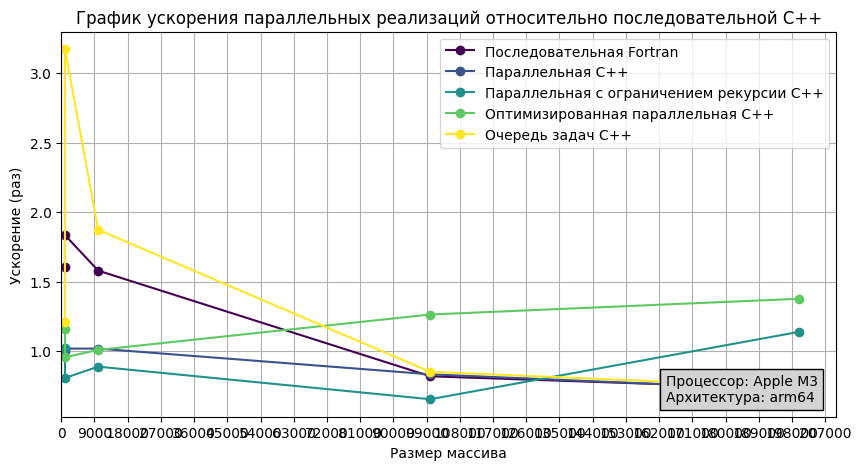

In [50]:
cpu_name = get_cpu_name()
architecture = platform.machine()

sequential_time = times["Последовательная C++"]

speedups = {}
for name, time_values in times.items():
    if name not in ["Последовательная C++", "Последовательная Fortrain"]:
        speedups[name] = [
            sequential_time[i] / time_values[i] if time_values[i] > 0 else float("inf")
            for i in range(len(sizes))
        ]

plt.figure(figsize=(10, 5))
colors = cm.viridis(np.linspace(0, 1, len(speedups)))

for (name, speedup_values), color in zip(speedups.items(), colors):
    plt.plot(sizes, speedup_values, marker='o', linestyle='-', color=color, label=name)

plt.xlabel("Размер массива")
plt.ylabel("Ускорение (раз)")
plt.title("График ускорения параллельных реализаций относительно последовательной C++")
plt.legend()
plt.grid(True)

plt.xlim(sizes[0], sizes[-1] + 10000)
xtick_step = 9000

plt.xticks(range(0, sizes[-1] + xtick_step, xtick_step))
cpu_info = f"Процессор: {cpu_name}\nАрхитектура: {architecture}"
plt.text(0.78, 0.04, cpu_info, transform=plt.gca().transAxes,
    fontsize=10, bbox=dict(facecolor='lightgray', edgecolor='black'))

plt.show()